In [15]:
# Notebook for checking what the galaxies classified as 'can't tell' look like, what their distributions look like etc.

from astropy.table import Table

# macbook additions
import numpy as np
from astropy.io import fits
import random
import math
import matplotlib.pyplot as plt
import os

import urllib
from PIL import Image

#-------------------------
% matplotlib inline
import matplotlib as mpl

#from prefig import Prefig
#Prefig()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

figsize=(5,5)
#-------------------------
clr = ['orange','r','purple','g','b']

In [2]:
def get_column(c,data,col_name):
  
    if len(c) == 2:
        column = data.field(c[0]) - data.field(c[1])
    else:
        column = data.field(c[0])
        if len(c) > 2:
            print(col_name + "has >2 fields. Only the first field was used.")
  
    return column

def load(cx,cy,p_th=0.5,N_th=5,mass_lim=False):

    gal_data = fits.getdata(source_dir + data_file,1) 
    debiased_values = fits.getdata(source_dir + debiased_file,1)
            
    x_column = get_column(c=cx,data=gal_data,col_name="x") 
    y_column = get_column(c=cy,data=gal_data,col_name="y") # Get the data from
    # the FITS file.
    
    f_v = np.array([debiased_values.field(c) 
                    for c in debiased_values.columns.names]).T
    
    table = np.concatenate([f_v,np.array([x_column,y_column]).T],axis=1)
    
    table = Table(table,names=('p_1','p_2','p_3','p_4','p_5','p_ct','x','y'))
        
    p_spiral = (
        gal_data.field("t01_smooth_or_features_a02_features_or_disk_debiased")
        *gal_data.field("t02_edgeon_a05_no_debiased")
        *gal_data.field("t04_spiral_a08_spiral_debiased"))
    N_spiral = (gal_data.field("t04_spiral_a08_spiral_count")) # Load values to
    # allow data cuts to be made.
    
    spiral_select = (p_spiral > p_th) & (N_spiral >= N_th)
    finite_select = (np.isfinite(table['x']))
    
    if mass_lim == True:
        mass_cut = gal_data.field('LOGMSTAR_BALDRY06') > 10.6
        full_table = table[finite_select & mass_cut]
        spiral_table = table[finite_select & spiral_select & mass_cut]
        
    else:
        full_table = table[finite_select]
        spiral_table = table[finite_select & spiral_select]

    return full_table,spiral_table

In [3]:
def assign(table,th=0,redistribute=False,rd_th=0,ct_th=0,print_sizes=False):

    m_columns = ['p_1','p_2','p_3','p_4','p_5','p_ct']
    
    m_array = np.array([table[column] for column in m_columns]).T
    m_array = m_array.astype(float)
    
    arm_assignments = np.ones(len(table))*(-999) # Assigned arm numbers 
    # initially is an array of -999s. -999 means 'no assignment'.
    for m in range(6):
        a = (np.argmax(m_array,axis=1) == m) & (m_array[:,m] >= th)
        arm_assignments[a] = m
        
    if redistribute is True: # Redistribute according to thresholds.
        for m in range(5):
            arm_assignments[(np.argmax(m_array[:,:5],axis=1) == m) 
                & (arm_assignments == 5) & (table[:,m]/table[:,5] > rd_th) 
                & (table[:,5] <= ct_th)] = m

    if print_sizes is True:
        print("total sample: " + str(len(arm_assignments)))
        print("total 'assigned' sample: " 
              + str(np.sum(arm_assignments != -999)))
        for m in range(6):
            print("m = " + str(m+1) + ": " 
                  + str(np.sum(arm_assignments == m)))
      
    return arm_assignments

In [4]:
# For plotting, clear differences are usually observed in the u-r vs. r-z contour plots

source_dir = '../../fits/'
data_file = 'volume_limited_sample.fits'
debiased_file = 'debiased_volume_limited_sample.fits'

all_gals,spirals = load(cx=['PETROMAG_MG','PETROMAG_MR'],cy=['PETROMAG_MR','PETROMAG_MZ'])
assignments = assign(spirals)
cant_tells = spirals[assignments == 5]

print("{} can't tell galaxies in total".format(len(cant_tells)))

3072 can't tell galaxies in total


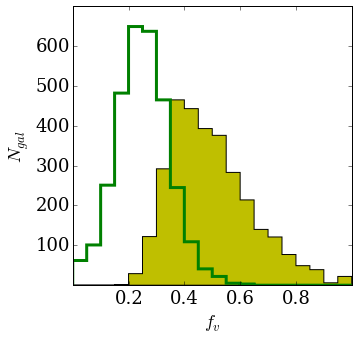

In [5]:
# Plot a histogram of the cant tell vote fractions:

plt.figure()

_ = plt.hist(cant_tells['p_ct'],histtype='stepfilled',color='y',bins=np.linspace(0,1,21))
plt.xlabel('$f_v$')
plt.ylabel('$N_{gal}$')

m_array = np.array([cant_tells[col] for col in ['p_1','p_2','p_3','p_4','p_5']])
_ = plt.hist(np.max(m_array,axis=0),histtype='step',color='g',bins=np.linspace(0,1,21),linewidth=3)

What we're 'looking to reproduce':


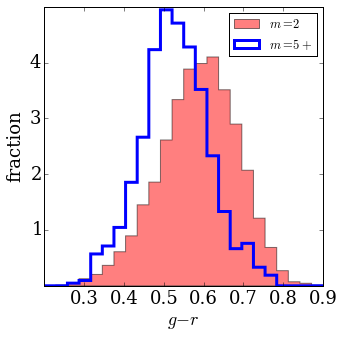

In [6]:
# Can see a clear difference in the g-r colourband, so we can use this as a guideline 
# ie. do the different samples have similar differences?

def plot_2vs5(sample,assignments):

    for m in [1,4]:

        if m == 1:
            style = 'stepfilled'
            l = 1
            a = 0.5
        else:
            style = 'step'
            l = 3
            a = 1
    
        spirals_m = sample[assignments == m]
        plt.hist(spirals_m['x'],color=clr[m],normed=True,histtype=style,linewidth=l,bins=np.linspace(0.2,0.9,25),alpha=a)
        plt.xlabel('$g-r$')
        plt.ylabel('fraction')
        
        plt.legend([r'$m=2$',r'$m=5+$'],fontsize=12.5)
  
    return None
    
plot_2vs5(spirals,assignments)

full_means = np.array([np.mean(spirals['x'][assignments == m]) for m in [1,4]])

print("What we're 'looking to reproduce':")

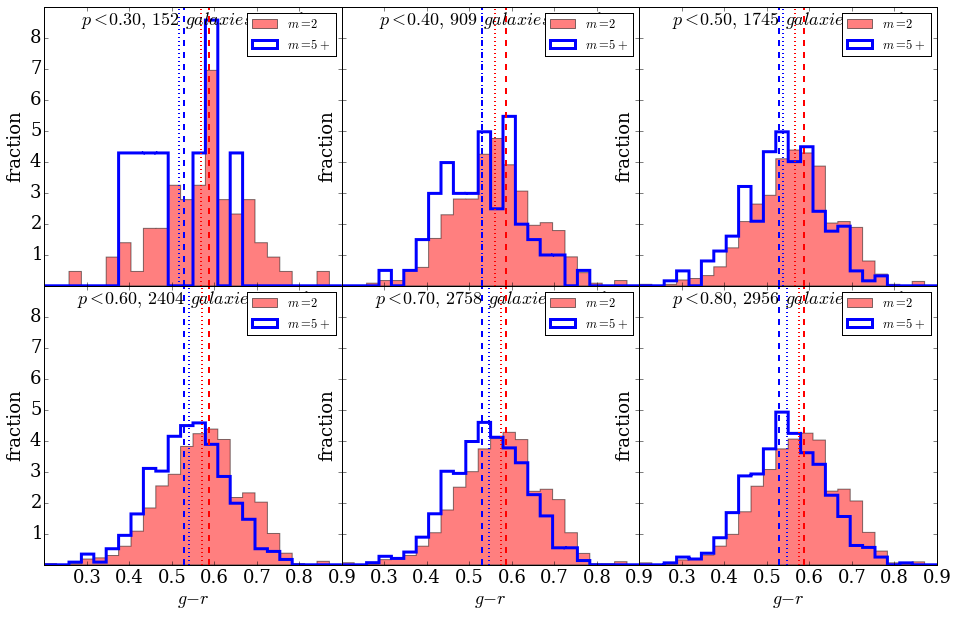

In [7]:
# Test different 'cutoff' points for the can't tell galaxies.

def plot_cut_distributions(cant_tells,cuts,full_means,axes):

    mean_list = np.zeros((len(cuts),2))

    for cut in enumerate(cuts):
    
        sample_cut = cant_tells['p_ct'] < cut[1]
        sample = cant_tells[sample_cut]
    
        m_array =  np.array([sample[col] for col in ['p_1','p_2','p_3','p_4','p_5']])
        assign = np.argmax(m_array,axis=0)
    
        plt.sca(axes[cut[0]])
        plot_2vs5(sample,assign)
        plt.text(0.5,0.99,r'$p < {{{0:.2f}}}$'.format(cut[1]) 
                 + r"$, \, {{{}}} \, galaxies \, saved$".format(len(sample))
                 ,transform=axes[cut[0]].transAxes, va='top',ha='center')
        
        
        mean_list[cut[0]] = np.array([np.mean(sample['x'][assign == m]) for m in [1,4]])
    
    for n in range(len(cuts)):
    
    # Plot some guidelines from the means of the full distributions.
    
        lims = axes[n].get_ylim()
    
        axes[n].vlines(full_means[0],lims[0],lims[1],color='r',linewidth=2,linestyle='dashed')
        axes[n].vlines(full_means[1],lims[0],lims[1],color='b',linewidth=2,linestyle='dashed')
        
        axes[n].vlines(mean_list[n,0],lims[0],lims[1],color='r',linewidth=2,linestyle='dotted')
        axes[n].vlines(mean_list[n,1],lims[0],lims[1],color='b',linewidth=2,linestyle='dotted')
        
    return None

fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,10))
axes = axes.ravel()
plt.subplots_adjust(hspace=0,wspace=0)

cuts = np.arange(0.3,0.81,0.1)
_ = plot_cut_distributions(cant_tells,cuts,full_means,axes)
    
# From this I'd actually conclude that we can do an OK job by redistributing almost everything...

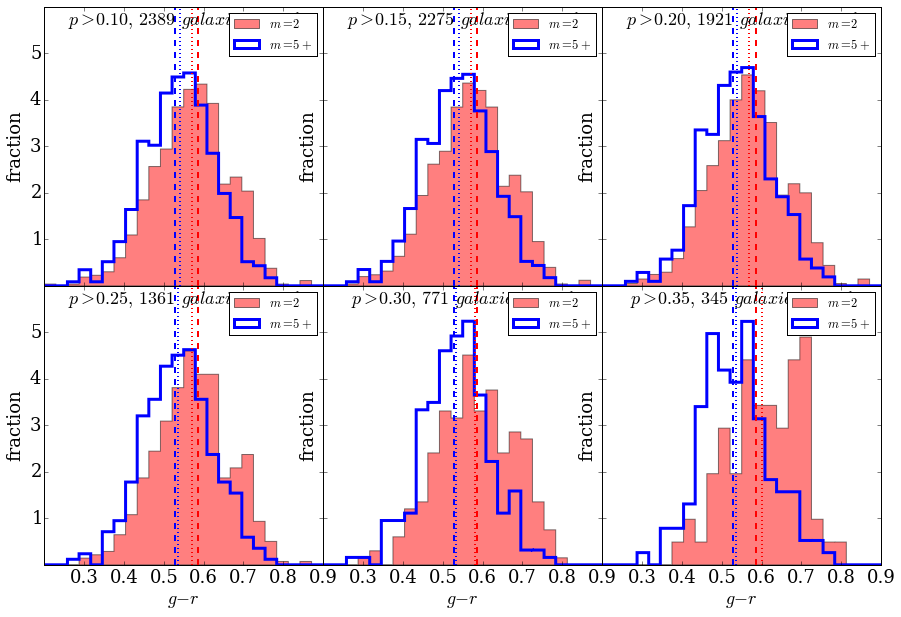

In [8]:
# Now make the cant tell cut at a given value and look into cutting further by the 'next best' value.

def plot_p_cut_distributions(cant_tells,p_vals,full_means,axes,cut_val):
    
    mean_list = np.zeros((len(cuts),2))

    for cut in enumerate(p_vals):
    
        sample_cut = cant_tells['p_ct'] < cut_val
        sample = cant_tells[sample_cut]
    
        m_array =  np.array([sample[col] for col in ['p_1','p_2','p_3','p_4','p_5']])
        assign = np.argmax(m_array,axis=0)
        
        p = np.max(m_array,axis=0)

        sample = sample[p >= cut[1]]
        assign = assign[p >= cut[1]]
    
        plt.sca(axes[cut[0]])
        
        if (np.sum(assign == 1) != 0) & (np.sum(assign == 4) != 0):
            plot_2vs5(sample,assign)
            
        plt.text(0.5,0.99,r'$p > {{{0:.2f}}}$'.format(cut[1]) 
                 + r"$, \, {{{}}} \, galaxies \, saved$".format(len(sample))
                 ,transform=axes[cut[0]].transAxes, va='top',ha='center')
        
        
        mean_list[cut[0]] = np.array([np.mean(sample['x'][assign == m]) for m in [1,4]])
    
    for n in range(len(p_vals)):
    
    # Plot some guidelines from the means of the full distributions.
    
        lims = axes[n].get_ylim()
    
        axes[n].vlines(full_means[0],lims[0],lims[1],color='r',linewidth=2,linestyle='dashed')
        axes[n].vlines(full_means[1],lims[0],lims[1],color='b',linewidth=2,linestyle='dashed')
        
        axes[n].vlines(mean_list[n,0],lims[0],lims[1],color='r',linewidth=2,linestyle='dotted')
        axes[n].vlines(mean_list[n,1],lims[0],lims[1],color='b',linewidth=2,linestyle='dotted')
        
    return None

fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,10))
axes = axes.ravel()
plt.subplots_adjust(hspace=0,wspace=0)

cut_value = 0.6
p_vals = np.linspace(0.1,0.35,6) # In this case I'll define p as the next best p_value

_ = plot_p_cut_distributions(cant_tells,p_vals,full_means,axes,cut_value)

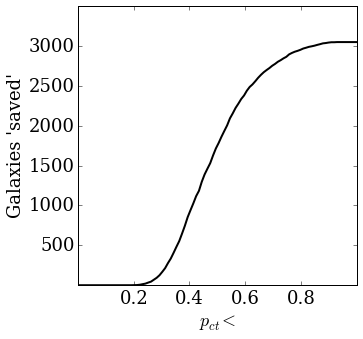

In [9]:
# How many galaxies do we 'save'?

cuts = np.linspace(0,1,100)

mean_list = np.zeros((len(cuts),2))
mean_list[:,0] = cuts

for cut in enumerate(cuts):
    total_left = np.sum(cant_tells['p_ct'] < cut[1])
    mean_list[cut[0],1] = total_left
    
plt.plot(mean_list[:,0],mean_list[:,1],'k-',linewidth=2)

plt.xlabel('$p_{ct}<$')
plt.ylabel("Galaxies 'saved'")

In [10]:
# Maybe look at this in another way- we have introduced a N >= 5 cut, so maybe only keep galaxies with 
# more than 5 arm number classifications?

def load_N(cx,cy,p_th=0.5,N_th=5,mass_lim=False):

    gal_data = fits.getdata(source_dir + data_file,1) 
    debiased_values = fits.getdata(source_dir + debiased_file,1)
            
    x_column = get_column(c=cx,data=gal_data,col_name="x") 
    y_column = get_column(c=cy,data=gal_data,col_name="y") # Get the data from
    # the FITS file.
    
    f_v = np.array([debiased_values.field(c) 
                    for c in debiased_values.columns.names]).T
    
    table = np.concatenate([f_v,np.array([x_column,y_column]).T],axis=1)
    
    table = Table(table,names=('p_1','p_2','p_3','p_4','p_5','p_ct','x','y'))
        
    p_spiral = (
        gal_data.field("t01_smooth_or_features_a02_features_or_disk_debiased")
        *gal_data.field("t02_edgeon_a05_no_debiased")
        *gal_data.field("t04_spiral_a08_spiral_debiased"))
    N_spiral = (gal_data.field("t04_spiral_a08_spiral_count")) # Load values to
    # allow data cuts to be made.
    
    # ADD THIS CAVEAT:-----
    N_ct = gal_data.field("t11_arms_number_a37_cant_tell_count")
    
    spiral_select = (p_spiral > p_th) & (N_spiral >= N_th) & ((N_spiral- N_ct) >= 5) # Added can't tell bit.
    #finite_select = (np.isfinite(table['x']))
    
    if mass_lim == True:
        mass_cut = gal_data.field('LOGMSTAR_BALDRY06') > 10.6
        full_table = table[mass_cut]
        spiral_table = table[spiral_select & mass_cut]
        
    else:
        full_table = table#[finite_select]
        spiral_table = table[spiral_select]

    return full_table,spiral_table

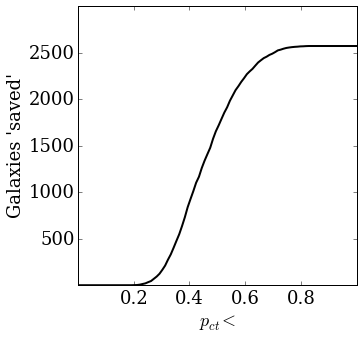

In [11]:
full_N,spirals_N = load_N(cx=['PETROMAG_MG','PETROMAG_MR'],cy=['jpeg_url'])
assignments_N = assign(spirals_N)
cant_tells_N = spirals_N[assignments_N == 5]

cuts = np.linspace(0,1,100)

mean_list = np.zeros((len(cuts),2))
mean_list[:,0] = cuts

for cut in enumerate(cuts):
    total_left = np.sum(cant_tells_N['p_ct'].astype(float) < cut[1])
    mean_list[cut[0],1] = total_left
    
plt.plot(mean_list[:,0],mean_list[:,1],'k-',linewidth=2)

plt.xlabel('$p_{ct}<$')
plt.ylabel("Galaxies 'saved'")

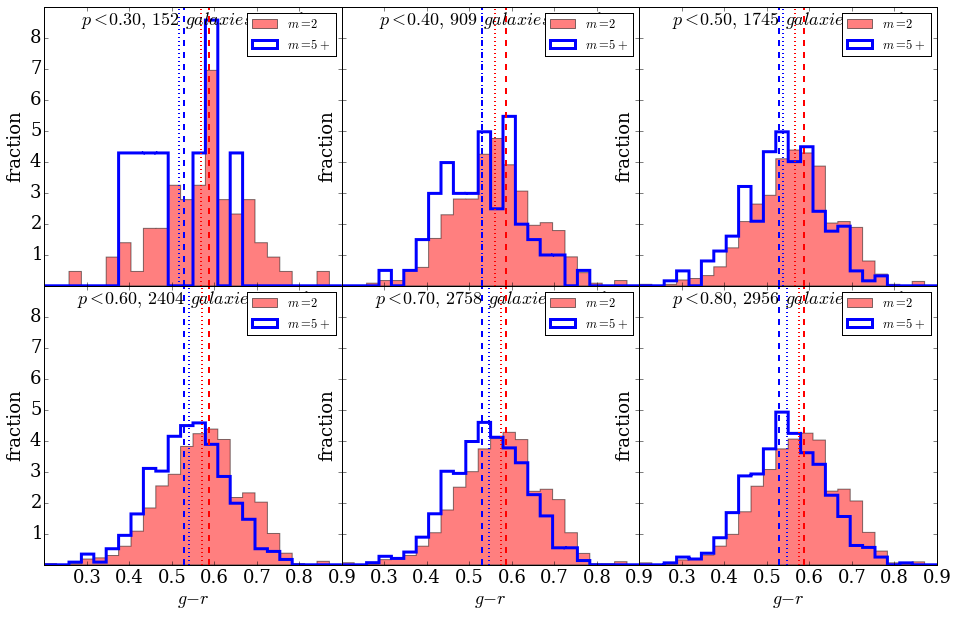

In [12]:
fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,10))
axes = axes.ravel()
plt.subplots_adjust(hspace=0,wspace=0)

cuts = np.arange(0.3,0.81,0.1)
_ = plot_cut_distributions(cant_tells,cuts,full_means,axes)

# Half-tempted to just lob them all in with N > 5 and p <~ 0.7 or something.
# Should now look to constrain this value where we throw out the can't tells.

In [13]:
# Now need to look in to images themselves to ensure we are 'correctly' redistributing?
from scipy.ndimage.filters import gaussian_filter

def display_image(url_name,crop_in=100):
    # Get the url name:
    urllib.request.urlretrieve(url_name,"image.jpg")
    # Open -> crop -> display -> remove the image.
    im=Image.open("image.jpg")
    l=424 # Image size
    im=im.crop((crop_in,crop_in,l-crop_in,l-crop_in))
    plt.imshow(im)
    os.remove("image.jpg")
    plt.xticks([])
    plt.yticks([])
    return None

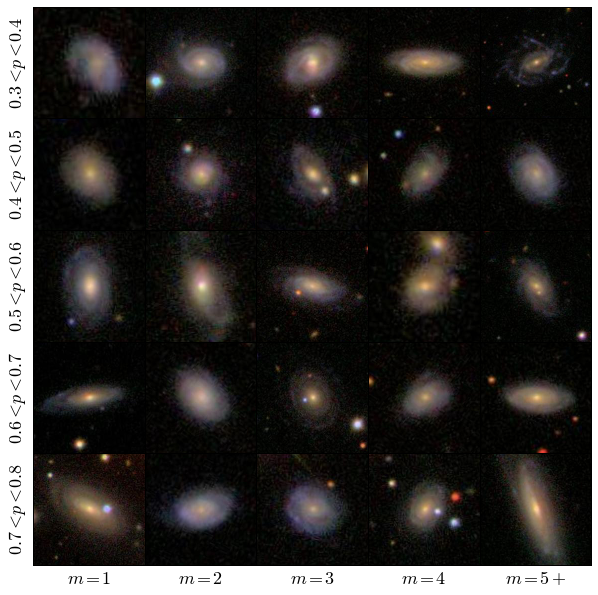

In [16]:
random.seed(2)

bins = np.digitize(cant_tells_N['p_ct'].astype(float),bins=np.arange(0.3,0.81,0.1))

fig,axes = plt.subplots(5,5,figsize=(10,10))
plt.subplots_adjust(hspace=0,wspace=0)

m_columns = ['p_1','p_2','p_3','p_4','p_5']

lx = ['$m=1$','$m=2$','$m=3$','$m=4$','$m=5+$']
ly = ['$0.3<p<0.4$','$0.4<p<0.5$','$0.5<p<0.6$','$0.6<p<0.7$','$0.7<p<0.8$']

for ax in enumerate(axes[-1,:]):
    ax[1].set_xlabel(lx[ax[0]])

for ax in enumerate(axes[:,0]):
    ax[1].set_ylabel(ly[ax[0]]) 
    
for bin_value in range(1,6):
    p_sample = cant_tells_N[bins == bin_value]
    
    m_array = np.array([p_sample[column] for column in m_columns]).T
    m_vals = np.argmax(m_array,axis=1)
    
    for m in range(5):
        m_sample = p_sample[m_vals == m]
        
        if len(m_sample) > 0:
            url = random.choice(m_sample['y'])
            plt.sca(axes[bin_value-1,m])
            display_image(url)

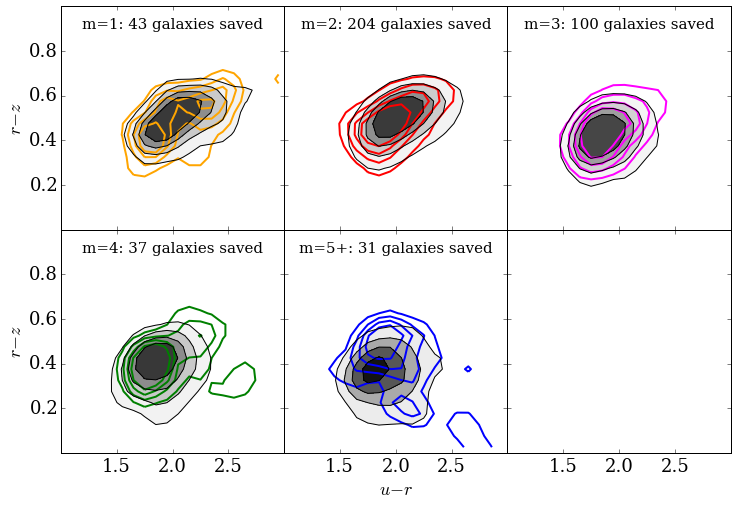

In [49]:
# Now look in to colour-colour diagrams and stellar masses 
# (the main intrinsic galaxy properties that are studied in the paper).

clr = ['orange','r','magenta','g','b']
titles = ['m=1','m=2','m=3','m=4','m=5+']

cut_ct = 0.4
N_b = 20

table,spirals = load_N(cx=['PETROMAG_MU','PETROMAG_MR'],cy=['PETROMAG_MR','PETROMAG_MZ'],mass_lim=True)

assignments = assign(spirals)
cant_tells = spirals[(assignments == 5) & (spirals['p_ct'] < cut_ct)]

m_array = np.array([cant_tells[column] for column in m_columns]).T
m_vals = np.argmax(m_array,axis=1)

fig,axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=(12,8))
plt.subplots_adjust(hspace=0,wspace=0)
axes = axes.ravel()
axes[0].set_xlim(1,3)
axes[0].set_ylim(0,1)
axes[4].set_xlabel('$u-r$')
axes[0].set_ylabel('$r-z$')
axes[3].set_ylabel('$r-z$')

levels = np.arange(1,4.1,1)

for m in range(5):
    
    values = cant_tells[m_vals == m]
    full_values = spirals[assignments == m]

    H,xedges,yedges = np.histogram2d(values['x'],values['y'],bins=N_b,range=[[1,3],[0,1]],normed=True)
    H_full,xedges,yedges = np.histogram2d(full_values['x'],full_values['y'],bins=N_b,range=[[1,3],[0,1]],normed=True)
    
    H_full = gaussian_filter(H_full,sigma=1)
    H = gaussian_filter(H,sigma=1)
    
    # Bin centres?
    xc = np.array([xedges[n] + (xedges[n+1] - xedges[n])/2 for n in range(N_b)])
    yc = np.array([yedges[n] + (yedges[n+1] - yedges[n])/2 for n in range(N_b)])
    
    axes[m].contour(xc,yc,H.T,linewidths=2,colors=clr[m],levels=levels)   
    axes[m].contourf(xc,yc,H_full.T,cmap='Greys',levels=np.append(levels,np.max(H_full)))
    axes[m].contour(xc,yc,H_full.T,colors='k',levels=np.append(levels,np.max(H_full)))
    
    axes[m].text(0.5,0.95,'{}: {} galaxies saved'.format(titles[m],len(values)),
                 ha='center',va='top',transform=axes[m].transAxes,size=15)

/Users/rosshart/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/rosshart/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


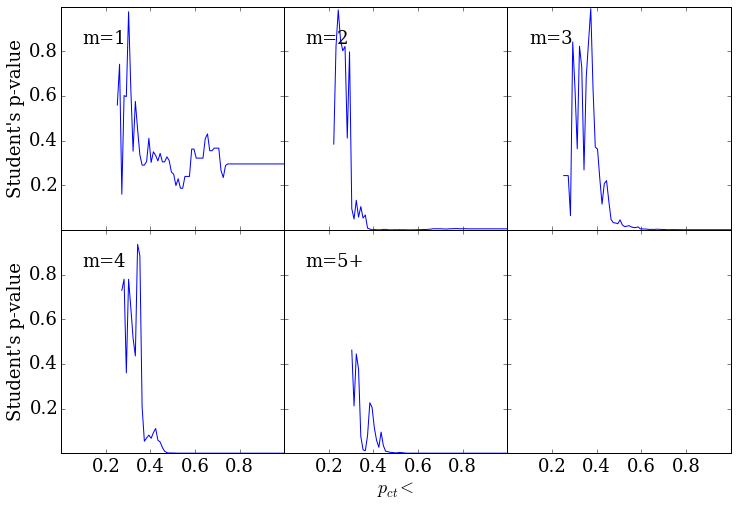

In [50]:
# Look in to Student's t-test as a function of p_ct
from scipy.stats import ttest_ind # independent or related?

table,spirals = load_N(cx=['PETROMAG_MG','PETROMAG_MR'],cy=['PETROMAG_MR','PETROMAG_MZ'],mass_lim=True)
assignments = assign(spirals)
cant_tells = spirals[(assignments == 5)]

m_array = np.array([cant_tells[column] for column in m_columns]).T
m_vals = np.argmax(m_array,axis=1)

t_test_results = np.zeros((2,100))

for m in range(5):
    full = spirals[assignments == m]

    for p_cut in enumerate(np.linspace(0,1,100)):
        
        redistributed = cant_tells[m_vals == m]
        redis_cut = redistributed[redistributed['p_ct'] < p_cut[1]]
        
        t,prob = ttest_ind(redis_cut['x'],full['x'],equal_var=False)
        t_test_results[:,p_cut[0]] = [p_cut[1],prob] 
        
    globals()['{}_t_results'.format(m)] = Table(t_test_results.T,names=('cut_value','p-value'))

# plot the p-values -------------------------
fig,axes = plt.subplots(2,3,figsize=(12,8),sharex=True,sharey=True)
axes = axes.ravel()

plt.subplots_adjust(hspace=0,wspace=0)
plt.xlim(0,1)
plt.ylim(0,1)
axes[0].set_ylabel("Student's p-value")
axes[3].set_ylabel("Student's p-value")
axes[4].set_xlabel('$p_{ct} < $')

for m in range(5):
    
    plot_data = globals()['{}_t_results'.format(m)]
    axes[m].plot(plot_data['cut_value'],plot_data['p-value'])
    axes[m].text(0.1,0.9,titles[m],ha='left',va='top')
    
# From looking at the Student's t-tests, value of 0.3~0.4 seems reasonable (looking at mass,
# u-r,g-r and r-z.